In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
import re

# Global data preparation

In [2]:
MF_data = pd.read_parquet('./data/MF_predictions.parquet')
df_full = MF_data.copy()
casp16 = pd.read_parquet('./data/casp16-capri.parquet')
oligo = pd.read_csv('./data/oligomerization.csv')

df_full['version'] = df_full['prediction'].str.split('multimer_').str[1].str.split('_').str[0]
df_full['pred_nb'] = df_full['prediction'].str.split('pred_').str[1].astype(int)
df_full['parameters'] = df_full['prediction'].str.split('_model').str[0]

max_dockq = df_full.groupby('target_id')['dockq'].max().reset_index()
max_dockq = max_dockq.rename(columns={"dockq": "max_dockq"})
q3_dockq = df_full.groupby('target_id')['dockq'].quantile(0.75).reset_index()
q3_dockq = q3_dockq.rename(columns={"dockq": "3rd_quantile_dockq"})
all_dockqs = max_dockq.merge(q3_dockq, on='target_id', how='left')
all_dockqs['max_q3_diff'] = all_dockqs["max_dockq"] - all_dockqs["3rd_quantile_dockq"]

# difficulty assignment
all_dockqs.loc[ (all_dockqs['max_dockq'] >= 0.6) & (all_dockqs["max_q3_diff"] <= 0.2), 'difficulty' ] = "easy"
all_dockqs.loc[ (all_dockqs['max_dockq'] >= 0.4) & (all_dockqs['max_dockq'] < 0.6), 'difficulty' ]  = "hard"
all_dockqs.loc[ (all_dockqs['max_dockq'] >= 0.4) & (all_dockqs["max_q3_diff"] > 0.2), 'difficulty' ]  = "hard"
all_dockqs.loc[ (all_dockqs['max_dockq'] < 0.4), 'difficulty' ]  = "extreme"

cat_ordered_list = ['incorrect', 'acceptable', 'medium', 'high']
casp16["main_classification"] = pd.Categorical(casp16["main_classification"], ordered = True, categories = cat_ordered_list)

# group & difficulty treatment
casp16.loc[(casp16["p_id"].isin(["MF_", "MF."])), "name"] = "MassiveFold-best"
p_types = ["S", "O", "C"]
all_difficulties = ['easy', 'moderate', 'hard', 'extreme']
casp16 = casp16[(~casp16['name'].isin(['target', 'interface', 'unbound'])) & (casp16["p_type"].isin(p_types))].merge(all_dockqs[["target_id", "difficulty"]], on='target_id', how='left')
casp16["participant"] = casp16["p_type"].map({"P": "Predictor", "S": "Scorer", "C": "Predictors", "O": "MassiveFold-best"})
casp16 = casp16[casp16['difficulty'].isin(all_difficulties)]

# re-index "broken" MF models
casp16["model2"] = casp16["model"].copy()
mask1 = casp16["p_id"] == "MF_"
casp16.loc[mask1, "model2"] = casp16[mask1]["identification"].str.split('.M').str[0].str.split("MF_").str[1].astype(int)
mask2 = casp16["p_id"] == "MF."
casp16.loc[mask2, "model2"] = casp16[mask2]["identification"].str.split('.M').str[1].astype(int)
casp16["model"] = casp16["model2"].copy()
casp16 = casp16.drop(columns={"model2"})
preds = casp16.copy()

MF_data['version'] = MF_data['prediction'].str.split('multimer_').str[1].str.split('_').str[0]
MF_data['pred_nb'] = MF_data['prediction'].str.split('pred_').str[1].astype(int)
MF_data['parameters'] = MF_data['prediction'].str.split('_model').str[0]
MF_eval = MF_data.merge(all_dockqs, on='target_id', how='right').drop_duplicates()
MF_eval["main_classification"] = pd.Categorical(MF_eval["main_classification"], ordered = True, categories = cat_ordered_list)

MF_eval = MF_eval.merge(
    preds[preds["name"] == "MassiveFold-best"][["target_id", "model", "dockq", "clashes", "nclash", "threshold"]].drop_duplicates(),
    on=["target_id", "model", "dockq", "clashes"],
    how='left')
AF2_baseline = MF_eval[(MF_eval['version'] == "v3") & (MF_eval["parameters"] == "afm_basic") & (MF_eval["pred_nb"] < 5)]
# 
scores = ["ipTM", "pTM"]
operations = ["median", "mean", "max"]
iptm_per_diff = AF2_baseline[["target_id", 'difficulty']].drop_duplicates().copy()
mf_metrics = MF_eval[["target_id", 'difficulty']].drop_duplicates().copy()
for s in scores:
    for ope in operations:
        iptm_per_diff = iptm_per_diff.merge(AF2_baseline.groupby(['target_id', 'difficulty'])[s.lower()].agg(ope).reset_index().rename(columns={s.lower(): f"Interfaces {ope} {s}"}))
        mf_metrics = mf_metrics.merge(MF_eval.groupby(['target_id', 'difficulty'])[s.lower()].agg(ope).reset_index().rename(columns={s.lower(): f"Interfaces {ope} {s}"}))
iptm_per_diff.loc[iptm_per_diff["difficulty"].isin(["hard", "extreme"]), "real_difficulty"] = 1
iptm_per_diff.loc[iptm_per_diff["difficulty"].isin(["easy"]), "real_difficulty"] = 0
iptm_per_diff["real_difficulty"] = pd.to_numeric(iptm_per_diff["real_difficulty"], errors="raise").astype(int)

# MF datasets: no relaxation so we keep models under 300 clashes (acceptable level pre-relaxation)
# All participants ('Brysbaert' included): keep only "non-clashed" models 
n_clash = 300
filtered_preds = preds[
    ((preds["name"] == "MassiveFold-best") & (preds["nclash"] < n_clash)) 
    |
    ((preds["name"] != "MassiveFold-best") & (preds["clashes"] == 0))
]
filtered_preds = filtered_preds.copy()
filtered_preds["target"] = filtered_preds["target_id"].str.split('.').str[0].str.replace('T', '').astype(int)
no_eco = filtered_preds.sort_values(['target_id', 'model']).reset_index(drop=True)

strat_cols = ["target_id", "model", "clashes", "dockq", "main_classification", "name", "participant", "parameters"]

af2 = AF2_baseline.copy()
af2["name"] = "AF2-baseline-best"
af2["participant"] = "AF2-baseline-best"
af2_best = af2.loc[af2.groupby('target_id')['iptm'].idxmax()]
af2_best["name"] = "AF2-baseline"
af2_best["participant"] = "AF2-baseline"

strategies = pd.concat(
    [no_eco,
     af2_best[strat_cols].merge(all_dockqs[["target_id", "difficulty"]], on='target_id'),
     af2[strat_cols].merge(all_dockqs[["target_id", "difficulty"]], on='target_id')],
    axis=0
)
thresholds = { 
    "S1": 0.8, "S2": 0.65, "S3": 0.571223,
    "S4": 1, "S5": 0.65, "S6": 0.571223
}
under_clash = MF_eval.copy()[MF_eval["nclash"] < n_clash]

for strat in ["S1", "S2", "S3"]:
    iptm_per_diff.loc[iptm_per_diff["Interfaces median ipTM"] <= thresholds[strat], strat] = "hard"
    iptm_per_diff.loc[iptm_per_diff["Interfaces median ipTM"] > thresholds[strat], strat] = "easy"
    eco_scenario = under_clash.merge(iptm_per_diff[["target_id", strat]])
    to_eco = eco_scenario[(eco_scenario[strat] == "easy")].drop_duplicates()
    to_eco = to_eco[(to_eco["parameters"] == "afm_basic") & (to_eco["version"] == "v3") & (to_eco['pred_nb'] < 5)]
    to_push = eco_scenario[(eco_scenario[strat] == "hard")].drop_duplicates()
    economised = pd.concat([to_eco, to_push], axis=0)
    economised = economised.sort_values(['target', 'target_id','parameters', 'model']).reset_index(drop=True)
    economised["name"] = f"MassiveFold-{strat}"
    economised["participant"] = f"MassiveFold-{strat}"
    strategies = pd.concat(
        [strategies, economised[strat_cols].merge(all_dockqs[["target_id", "difficulty"]], on='target_id')],
        axis=0
    )

unused_params = [ 
    'afm_dropout_full_woTemplates_r3',
    'cf_dropout_full_woTemplates',
    'afm_dropout_full_woTemplates' 
]
sampling = 32
for strat in ["S4", "S5", "S6"]:
    iptm_per_diff.loc[iptm_per_diff["Interfaces median ipTM"] <= thresholds[strat], strat] = "hard"
    iptm_per_diff.loc[iptm_per_diff["Interfaces median ipTM"] > thresholds[strat], strat] = "easy"
    eco_scenario = under_clash.merge(iptm_per_diff[["target_id", strat]])
    to_eco = eco_scenario[(eco_scenario[strat] == "easy")].drop_duplicates()
    to_eco = to_eco[(to_eco["parameters"] == "afm_basic") & (to_eco["version"] == "v3") & (to_eco['pred_nb'] < 5)]
    
    to_push = eco_scenario[
        (eco_scenario[strat] == "hard") &
        (eco_scenario["pred_nb"] <= sampling) &
        (~eco_scenario["parameters"].isin(unused_params))
    ].drop_duplicates()
    economised = pd.concat([to_eco, to_push], axis=0)
    economised = economised.sort_values(['target', 'target_id','parameters', 'model']).reset_index(drop=True)
    economised["name"] = f"MassiveFold-{strat}"
    economised["participant"] = f"MassiveFold-{strat}"
    strategies = pd.concat(
        [strategies, economised[strat_cols].merge(all_dockqs[["target_id", "difficulty"]], on='target_id')],
        axis=0
    )

In [3]:
def plot_ranking(df, ax, save='', do='show', new_styles=None, palette=None):
    sns.set_style("whitegrid", {"grid.alpha": 1.0})
    df = df.copy()

    styles = {
        "linewidth": {"high": 0.7, "medium": 0.7, "acceptable": 0.7},
        "sizes": 30
    }
    if new_styles:
        styles.update(new_styles)
        for i in new_styles:
            if isinstance(new_styles[i], dict):
                styles[i].update(new_styles[i])
            if isinstance(new_styles[i], int) or isinstance(new_styles[i], float):
                styles[i] = new_styles[i]
    df["name_participant"] = df["name"] + "_" + df["participant"]

    if not palette:
        palette = { "Predictors": "mediumturquoise", "Scorer": "cadetblue", "MassiveFold-best": "darkslategray" }

    cumumative_dockqs = df\
        .groupby(['target_id', 'name_participant'])['dockq'].max().reset_index()\
        .groupby(['name_participant'])['dockq'].sum().reset_index()

    max_classification = df\
        .groupby(['target_id', 'name_participant'])['main_classification'].max().reset_index()
    max_classif_counts = pd.crosstab(
            max_classification['name_participant'],
            max_classification['main_classification']
    ).rename_axis(None, axis=1).reset_index()

    final_df = cumumative_dockqs.merge(max_classif_counts, on='name_participant', how='left')
    final_df['score'] = 3*final_df['high'] + 2*final_df['medium'] + 1*final_df['acceptable']
    final_df["participant"] = final_df["name_participant"].str.split('_').str[-1]
    unique_participants = final_df["participant"].unique().tolist()
    mf_participants = [ 
        i for i in ["MassiveFold-best", "MassiveFold-S1", "MassiveFold-S2", "MassiveFold-S3", "AF2-baseline-best", "AF2-baseline"]
        if i in unique_participants
    ]
    others = [ i for i in unique_participants if i not in mf_participants ]
    all_participants = [*mf_participants, *others][::-1]
    final_df["participant"] = pd.Categorical(final_df["participant"], ordered = True, categories = all_participants)
    final_df = final_df.sort_values(['score', 'dockq', "participant"], ascending=False).reset_index()
    sns.barplot(
        final_df,
        x="name_participant",
        y="dockq",
        ax=ax,
        hue='participant',
        hue_order=all_participants[::-1],
        palette=palette,
        dodge=False
    )
    sns.despine()

    final_df["name"] = final_df['name_participant'].str.split('_').str[:-1].str.join('_')
    x_labels = final_df["name"].tolist()

    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(x_labels, rotation=90, horizontalalignment='center')
    ax.set_xlabel('')
    ax.set_ylabel("Cumulative DockQ\n& Count of best prediction classifications")
    
    x_all = np.arange(len(final_df))
    classifications = ["high", "medium", 'acceptable']
    markers         = ['D', '^', 'x']
    colors          = ['firebrick', 'seagreen', 'cornflowerblue']
    linewidth       = [styles["linewidth"]["high"], styles["linewidth"]["medium"], styles["linewidth"]["acceptable"]]
    # overlay scatter for each class
    for i, (cls, mkr, col, s) in enumerate(zip(classifications, markers, colors, linewidth)):
        mask = final_df[cls] != 0
        x = x_all[mask]
        y = final_df.loc[mask, cls]
        ax.scatter(
            x,
            y,
            marker=mkr,
            color=col,
            s=styles["sizes"],
            linewidth=s,
            zorder=10-i,
            label=cls
        )
    f_len = 0.07
    f_gap = 0.02
    fig = ax.figure
    fig.canvas.draw()
    
    group = 'Brysbaert'
    mf = "MassiveFold-best"
    df = final_df.copy()
    
    x_val = df.index[df['name'] == group][0]
    y_val = df.loc[df['name'] == group, 'dockq'].item()
    # 1) find 'Brysbaert' bar
    mf_xval = df.index[df['participant'] == mf][0]
    mf_yval = df.loc[df['participant'] == mf, 'dockq'].item()
    # 2) compute a data‐unit gap above the bar:
    y0, y1 = ax.get_ylim()
    gap_data = f_gap * (y1 - y0)
    # 3) compute on‐screen axis height in points → arrow‐shaft length
    renderer = fig.canvas.get_renderer()
    bbox = ax.get_window_extent(renderer)
    height_px = bbox.height
    height_pt = height_px * 72.0 / fig.dpi
    offset_pts = f_len * height_pt
    # 4) draw the arrow: head at (x_val, y_val + gap_data), 
    # tail `offset_pts` above that (in points)
    ax.annotate(
        "",
        xy=(x_val, y_val + gap_data),
        xycoords="data",
        xytext=(0, offset_pts),
        textcoords="offset points",
        arrowprops=dict(
            facecolor="firebrick",
            edgecolor="none",
            width=4,
            headwidth=7,
            headlength=7,
            shrink=0
        ),
        zorder=0
    )
    
    ax.annotate(
        "",
        xy=(mf_xval, mf_yval + gap_data),
        xycoords="data",
        xytext=(0, offset_pts),
        textcoords="offset points",
        arrowprops=dict(
            facecolor="forestgreen",
            edgecolor="none",
            width=4,
            headwidth=7,
            headlength=7,
            shrink=0
        ),
        zorder=0
    )

    return final_df, ax

# Figure 1: class difficulties

## Data preparation

In [4]:
# a: difficulty thresholds
x, y = np.linspace(0, 1, 300), np.linspace(0, 1, 300)
X, Y = np.meshgrid(x, y)
Z = np.full_like(X, np.nan)
mask1 = (Y < 0.4)
mask2 = ((Y >= 0.4) & (Y < 0.6)) | ((Y >= 0.6) & (X > 0.2))
mask3 = (Y >= 0.6) & (X <= 0.2)
Z[mask1], Z[mask2], Z[mask3] = 1, 2, 3
cmap = matplotlib.colors.ListedColormap(['grey', 'peru', 'mediumaquamarine'])

# e: roc curves
cols_to_keep = [ i for i in iptm_per_diff.columns if 'max' not in i ]
roc_df = iptm_per_diff[cols_to_keep]
score_cols= [ i for i in cols_to_keep if i not in 
             ["target_id", "difficulty", "real_difficulty", "S1", "S2", "S3", 'S4', 'S5', 'S6'] 
            ]
roc_df.columns = roc_df.columns.str.replace('Interfaces', '', regex=False)
score_cols = [ col.replace('Interfaces', '') for col in score_cols ]
y_true = pd.to_numeric(roc_df["real_difficulty"], errors='raise').astype(int).values
results, roc_data = [], []
for col in score_cols:
    scores = pd.to_numeric(roc_df[col], errors='raise').astype(float).values
    y_score = -scores
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    thresh = np.unique(scores)
    f1s = [f1_score(y_true, (scores <= T).astype(int)) for T in thresh]
    ix = int(np.argmax(f1s))
    results.append({'score_col': col, 'auc': auc, 'best_threshold': thresh[ix], 'f1_score': f1s[ix]})
    roc_data.append(pd.DataFrame(
        {'False Positive Rate': fpr, 'True Positive Rate': tpr, 'score_col': f"{col} (AUC={auc:.3f})"})
    )
roc_df = pd.concat(roc_data, ignore_index=True)

## Figure 1

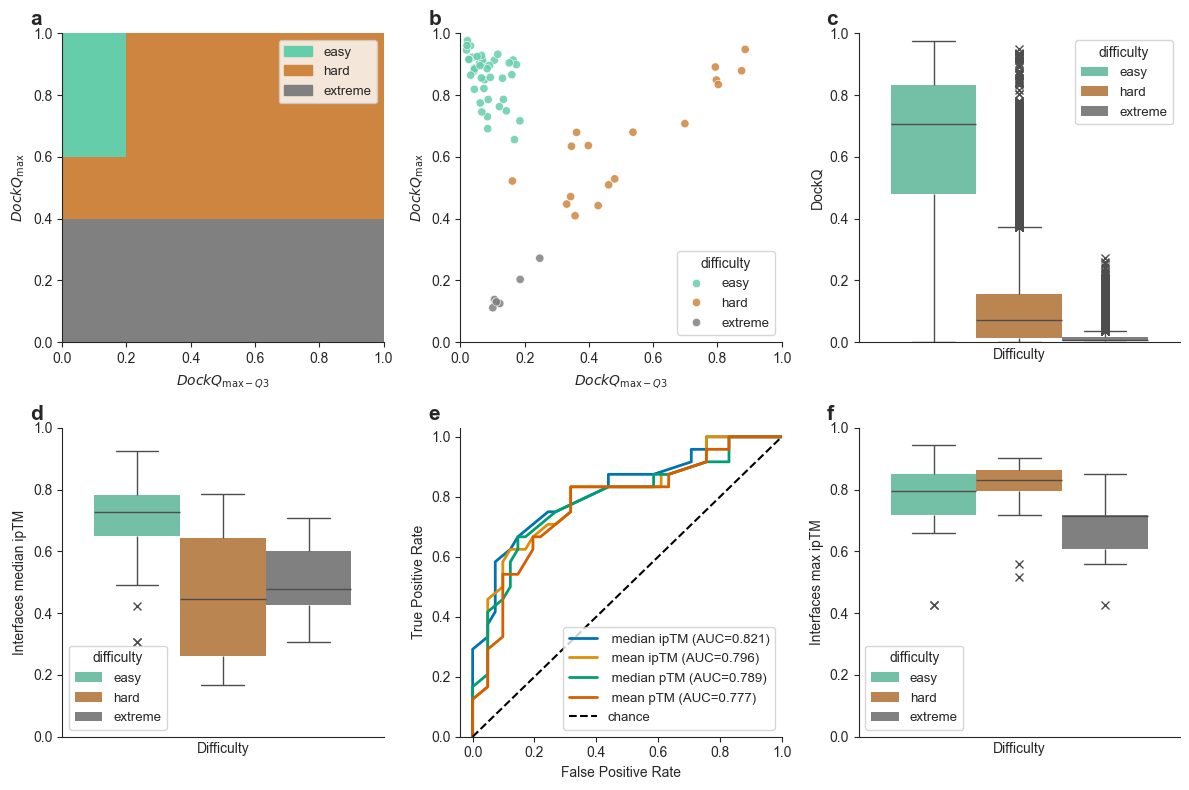

In [5]:
sns.set_style('ticks')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes = axes.flatten()
alpha=0.85
cat_palette = {"easy": "mediumaquamarine", "hard": "peru", "extreme": "gray"}

# a: difficulty thresholds
axes[0].pcolormesh(X, Y, Z, cmap=cmap, vmin=1, vmax=3, shading='nearest',
                   edgecolors='none', rasterized=True)
patches = [ matplotlib.patches.Patch(color=cat_palette[diff], label=diff) for diff in cat_palette ]
axes[0].legend(handles=patches, loc='upper right')
# b: target threshold 
sns.scatterplot(all_dockqs, x='max_q3_diff', y='max_dockq', hue='difficulty',
                palette=cat_palette, ax=axes[1], alpha=alpha)
# c: DockQ distrib per class
merged = df_full.merge(all_dockqs, on='target_id', how='left')
sns.boxplot(merged, y='dockq', hue='difficulty', palette=cat_palette, 
            ax=axes[2], boxprops={"edgecolor": "none"}, flierprops={"marker": "x"})
axes[2].set_ylabel('DockQ')
# d: median ipTM with AF2 baseline
sns.boxplot(iptm_per_diff, y="Interfaces median ipTM", hue='difficulty', ax=axes[3],
            palette=cat_palette, boxprops={"edgecolor": "none"}, flierprops={"marker": "x"})
# e: roc curves
sns.lineplot(data=roc_df, x='False Positive Rate', y='True Positive Rate', hue='score_col',
             ax=axes[4], palette='colorblind', linewidth=2, estimator=None, errorbar=None,)
axes[4].plot([0, 1], [0, 1], 'k--', label='chance')
axes[4].legend(title='')
# f: max ipTM on MassiveFold data
sns.boxplot(mf_metrics, y="Interfaces max ipTM", hue='difficulty', ax=axes[5],
            palette=cat_palette, boxprops={"edgecolor": "none"}, flierprops={"marker": "x"})
# titles and figure params
for i, letter in enumerate(['a', 'b', 'c', 'd', 'e', 'f']):
    axes[i].set_title(letter, loc="left", fontweight="bold", x=-.1, fontsize=15)
    axes[i].set_ylim(0, 1)
    if i in [0, 1]:
        axes[i].set_xlabel(r'$DockQ_{\max-Q3}$')
        axes[i].set_ylabel(r'$DockQ_{\max}$')
    if i in [0, 1, 4]:
        axes[i].set_xlim(0, 1)
    if i in [2, 3, 5]:
        axes[i].set_xticks([])
        axes[i].set_xlabel('Difficulty')
        for artist in axes[i].artists:
            artist.set_alpha(alpha)
    if i == 4:
        axes[i].set_ylim(0, 1.03)
        axes[i].set_xlim(-0.04, 1)
    leg = axes[i].get_legend()
    if leg is not None:
        for text in leg.get_texts():
            text.set_fontsize(9.5)
sns.despine()
plt.tight_layout()
plt.show()
#plt.savefig("./Figure_1.png", dpi=300)

# Figure 2: participants ranking vs. MassiveFold strategies

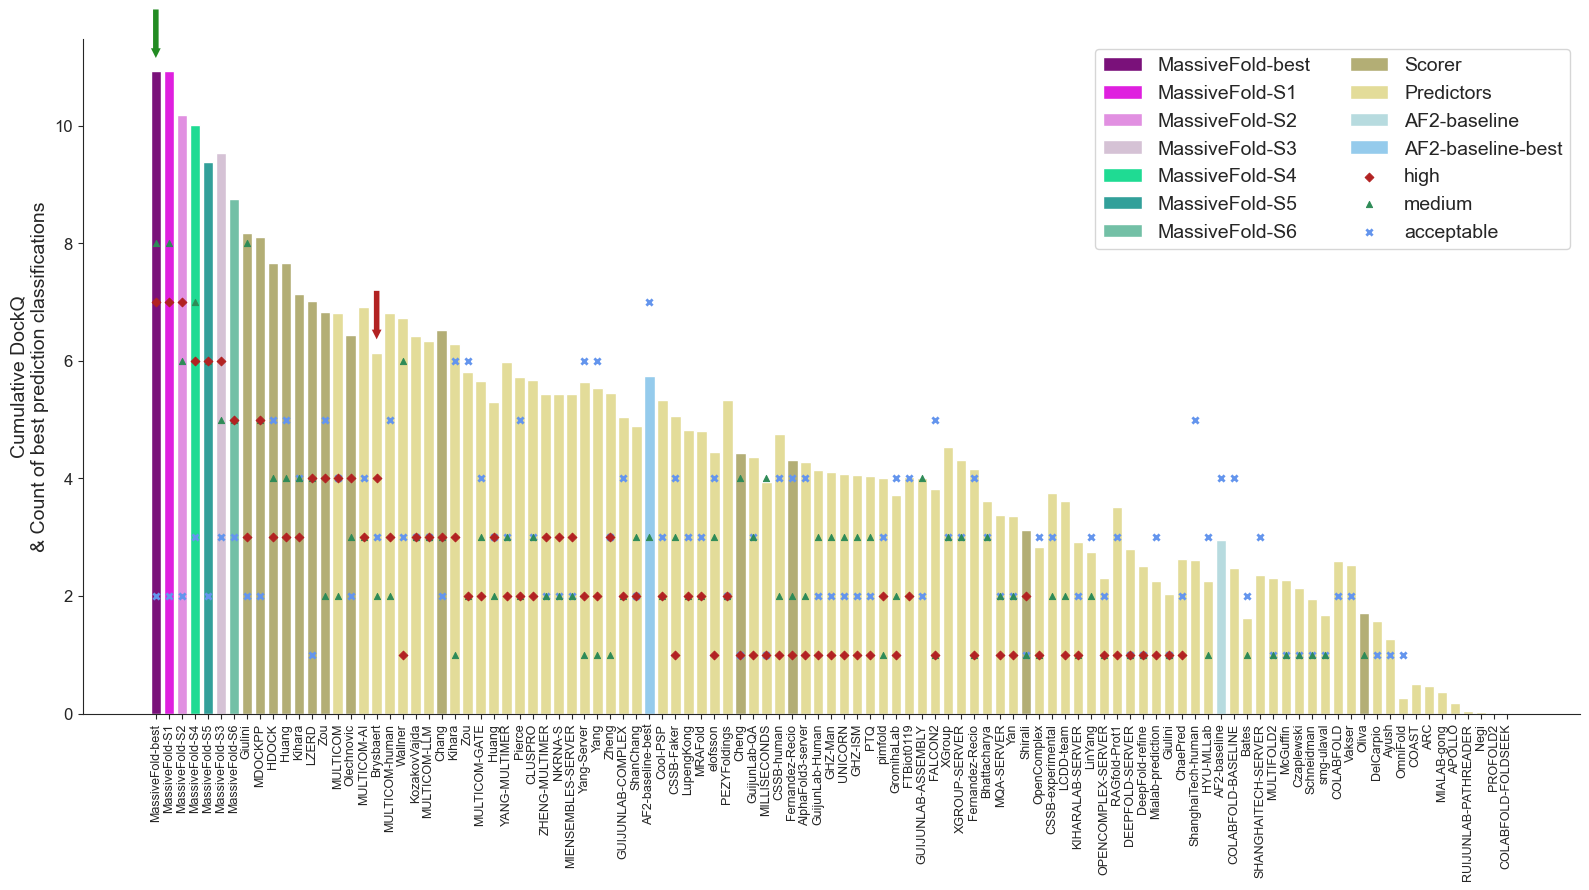

In [20]:
all_palette = {
    "MassiveFold-best": "darkmagenta",
    #"MassiveFold-full": "darkviolet",
    "MassiveFold-S1": "magenta",
    "MassiveFold-S2": "violet",
    "MassiveFold-S3": "thistle",
    "MassiveFold-S4": "mediumspringgreen",
    "MassiveFold-S5": "lightseagreen",
    "MassiveFold-S6": "mediumaquamarine",
    "Scorer": "darkkhaki",
    "Predictors": "khaki",
    "AF2-baseline": "powderblue",
    "AF2-baseline-best": "lightskyblue"
}
styles = {"linewidth": {"high": 0.7, "medium": 0.7, "acceptable": 2},
          "sizes": 20}

sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(16, 9))
#col_order = [ i for i in all_palette ]
plot_ranking(strategies[strategies["difficulty"] == "hard"], ax, palette=all_palette, new_styles=styles)

ax.tick_params(axis='x', labelsize=9)
ax.tick_params(axis='y', labelsize=12)

desired_order = [ i for i in all_palette ]
handles, labels = ax.get_legend_handles_labels()
label_to_handle = dict(zip(labels, handles))
ordered_handles = [label_to_handle[label] for label in desired_order]
ordered_handles.extend([i for i in handles if i not in ordered_handles])

ordered_labels = desired_order
ordered_labels.extend([i for i in labels if i not in desired_order])
    
ax.legend(ordered_handles, ordered_labels, ncol=2, fontsize=14)

ax.set_ylabel(ax.get_ylabel(), fontsize=14)
plt.tight_layout()
plt.show()
#plt.savefig("./Figure_2.png", dpi=300)

# Supplementary Materials

## Data Preparation for Suplementary Materials

In [9]:
timings = pd.read_parquet('./data/all_timings.parquet')
recap = pd.read_csv('./data/recap_targets.csv')

participants = [
    "MassiveFold-best",
    "MassiveFold-S1",
    "MassiveFold-S2",
    "MassiveFold-S3",
    "MassiveFold-S4",
    "MassiveFold-S5",
    "MassiveFold-S6",
    "AF2-baseline-best",
    "AF2-baseline"
]
all_methods = [
    "MassiveFold-best", "AF3-best", "AF2-all-best", "AF2-all",
    "AF2-v3-best", "AF2-v3", "AF2-v2-best", "AF2-v2", "AF2-v1-best", "AF2-v1"
]
all_palette = {
    "MassiveFold-best": "darkmagenta", 
    "MassiveFold-S1": "magenta", "MassiveFold-S2": "violet", "MassiveFold-S3": "thistle",
    "MassiveFold-S4": "mediumspringgreen", "MassiveFold-S5": "lightseagreen", "MassiveFold-S6": "mediumaquamarine",
    
    "S1": "magenta", "S2": "violet", "S3": "thistle", 
    "S4": "mediumspringgreen", "S5": "lightseagreen", "S6": "mediumaquamarine",
    "MassiveFold parameters (best)": "rosybrown", "MassiveFold parameters": "burlywood", "MassiveFold-baseline": "darkslateblue",
    
    "AF2-baseline-best": "lightskyblue", "AF2-baseline": "powderblue", "AF3-best": "gold", 
    "AF2-all-best": "firebrick", "AF2-all": "lightcoral", "AF2-v3-best": "lightskyblue",
    "AF2-v3": "powderblue", "AF2-v2-best": "darkgoldenrod", "AF2-v2": "darkorange",
    "AF2-v1-best": "darkgreen", "AF2-v1": "lime", "Scorer": "darkkhaki", "Predictors": "khaki",
}

df_methods = strategies[["target_id", "difficulty"]].drop_duplicates(ignore_index=True)
df_methods = df_methods.merge(
    strategies[strategies["name"] == "MassiveFold-best"].groupby("target_id")["dockq"].max().reset_index().rename(columns={"dockq": "MassiveFold-best"}),
    on="target_id",
    how='left'
)

clash_mask = MF_eval["nclash"] < 300
afm_mask = (MF_eval["parameters"] == "afm_basic") & (MF_eval["pred_nb"] < 5)

name = "AF3-best"
af3 = strategies[strategies["name"] == "AlphaFold3-server"]
af3_best = af3.groupby("target_id")["dockq"].max().reset_index().rename(columns={"dockq": name})
df_methods = df_methods.merge(af3_best, on='target_id', how='left')
df_methods[name] = df_methods[name].fillna(0)
name = "AF2-all-best"
af2_all = MF_eval[(clash_mask) & (afm_mask)]
best_af2_all = af2_all.groupby("target_id")["dockq"].max().reset_index().rename(columns={"dockq": name})
df_methods = df_methods.merge(best_af2_all, on='target_id', how='left')
df_methods[name] = df_methods[name].fillna(0)
top_name = name.replace('-best', '')
top_af2_all = af2_all.loc[af2_all.groupby('target_id')['iptm'].idxmax()][["target_id", "dockq"]].rename(columns={"dockq": top_name})
df_methods = df_methods.merge(top_af2_all, on='target_id', how='left')
df_methods[top_name] = df_methods[top_name].fillna(0)

for version in ["v1", "v2", "v3"]:
    name = f"AF2-{version}-best"
    af2v = MF_eval[(clash_mask) & (afm_mask) & (MF_eval["version"] == version)]
    best_af2v = af2v.groupby("target_id")["dockq"].max().reset_index().rename(columns={"dockq": name})
    df_methods = df_methods.merge(best_af2v, on='target_id', how='left')
    df_methods[name] = df_methods[name].fillna(0)
    
    top_name = name.replace('-best', '')
    top_af2v = af2v.loc[af2v.groupby('target_id')['iptm'].idxmax()][["target_id", "dockq"]].rename(columns={"dockq": top_name})
    df_methods = df_methods.merge(top_af2v, on='target_id', how='left')
    df_methods[top_name] = df_methods[top_name].fillna(0)

whole = strategies[["target_id", "difficulty"]].drop_duplicates(ignore_index=True).sort_values('target_id')
easy, hard, extreme = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for participant in participants:
    df_selected = strategies.copy()[strategies["participant"] == participant].groupby('target_id')["dockq"].max().reset_index()
    df_selected = df_selected.rename(columns={'dockq': participant})
    inter = pd.DataFrame({"target_id": df_selected["target_id"].unique().tolist()})\
        .merge(df_selected, on='target_id', how='left')
    whole = whole.merge(inter, on='target_id', how='left')
    inter_easy, inter_hard, inter_extreme = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    inter_easy["dockq"] = whole[whole["difficulty"] == "easy"][participant].fillna(0).cumsum()
    inter_easy["method"] = participant
    easy = pd.concat([easy, inter_easy.reset_index()], axis=0)
    inter_hard["dockq"] = whole[whole["difficulty"] != "easy"][participant].fillna(0).cumsum()
    inter_hard["method"] = participant
    hard = pd.concat([hard, inter_hard.reset_index()], axis=0)

T250 = recap[recap["target"] == "T1249"]
T250["CAPRI_id"] = "T250"
T252 = T250.copy()
T252["CAPRI_id"] = "T252"

recap = pd.concat([ recap[recap["target"] != "T1249"], T250, T252 ], axis=0)
iptm_per_diff["CAPRI_id"] = iptm_per_diff["target_id"].str.split('.').str[0]
iptm_per_diff = iptm_per_diff.merge(recap[["CAPRI_id", "total_predictions", "target"]], how='left')

a100 = timings["gpu"] == "a100"
v100 = timings["gpu"] == "v100"

timings.loc[a100, 'corrected_time'] = timings[a100]["time"]*2
timings.loc[v100, 'corrected_time'] = timings[v100]["time"]

# separate models with 3 recycles (run dropout_full_woTemplates_r3) and others
# biggest time diff for 2 prediction of same target is recyclings
not_3 = timings[timings["recycling"] != 3].groupby('target')["corrected_time"].mean().reset_index()
not_3 = not_3.rename(columns={"corrected_time": "recycling_time"})
rec_3 = timings[timings["recycling"] == 3].groupby('target')["corrected_time"].mean().reset_index()
rec_3 = rec_3.rename(columns={"corrected_time": "time_3_recycles"})

times = iptm_per_diff[["target"]].drop_duplicates()\
    .merge(not_3, on='target', how='left')\
    .merge(rec_3, on='target', how='left')
mask_nan = times["recycling_time"].isna()
times.loc[mask_nan, 'recycling_time'] = times[mask_nan]["time_3_recycles"]
for key, treshold in zip(
        [f"pred_difficulty{i}" for i in [1, 2, 3]],
        [0.8, 0.65, 0.571223]):
    iptm_per_diff.loc[iptm_per_diff["Interfaces median ipTM"] <= treshold, key] = "hard"
    iptm_per_diff.loc[iptm_per_diff["Interfaces median ipTM"] > treshold, key] = "easy"
for key, treshold in zip(
        [f"pred_difficulty{i}" for i in [4, 5, 6]],
        [1, 0.65, 0.571223]):
    iptm_per_diff.loc[iptm_per_diff["Interfaces median ipTM"] <= treshold, key] = "hard"
    iptm_per_diff.loc[iptm_per_diff["Interfaces median ipTM"] > treshold, key] = "easy"

time_merged = iptm_per_diff.merge(times, on='target', how='left')
mask_8040 = time_merged["total_predictions"] == 8040
mask_not = time_merged["total_predictions"] != 8040
time_merged.loc[mask_8040, "total_time(s)"] = 1005*time_merged[mask_8040]["time_3_recycles"] + 7035*time_merged[mask_8040]["recycling_time"]
time_merged.loc[mask_not, "total_time(s)"] = time_merged[mask_not]["total_predictions"] * time_merged[mask_not]["recycling_time"]
time_merged["MassiveFold-best(h)"] = time_merged["total_time(s)"]/3600
time_merged["AF2-baseline(h)"] = (25*time_merged["recycling_time"])/3600

for diff, strat in zip(
    ["pred_difficulty1", "pred_difficulty2", "pred_difficulty3"],
    ["S1(h)", "S2(h)", "S3(h)", "S4(h)", "S5(h)", "S6(h)"]):
    times_easy = time_merged[diff] == "easy"
    times_hard = time_merged[diff] == "hard"
    time_merged.loc[times_easy, strat] = (25*time_merged[times_easy]["recycling_time"])/3600
    time_merged.loc[times_hard, strat] = time_merged[times_hard]["MassiveFold-best(h)"]

time_merged.loc[mask_8040, "reduced_time(s)"] = 2475*time_merged[mask_8040]["recycling_time"]
time_merged.loc[mask_not, "reduced_time(s)"] = time_merged[mask_not]["total_predictions"] * time_merged[mask_not]["recycling_time"]
time_merged["S4(h)"] = time_merged["reduced_time(s)"]/3600

for diff, strat in zip(
    ["pred_difficulty5", "pred_difficulty6"],
    ["S5(h)", "S6(h)"]):
    times_easy = time_merged[diff] == "easy"
    times_hard = time_merged[diff] == "hard"
    time_merged.loc[times_easy, strat] = (25*time_merged[times_easy]["recycling_time"])/3600
    time_merged.loc[times_hard, strat] = time_merged[times_hard]["S4(h)"]

time_merged[
    ["CAPRI_id", "pred_difficulty1", "pred_difficulty2", "pred_difficulty3",
     'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S1(h)', 'S2(h)', 'S3(h)', 'S4(h)',
     'S5(h)', 'S6(h)'
    ]
]

methods = ["MassiveFold-best", 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'AF2-baseline']

final_methods, m_times, difficulties = [], [], []
for method in methods:
    method_key = f"{method}(h)"
    df_selected = time_merged[["CAPRI_id", "difficulty", method_key]].drop_duplicates()
    for diff in df_selected["difficulty"].unique():
        difficulties.append(diff)
        m_times.append(df_selected[df_selected["difficulty"] == diff][method_key].sum())
        final_methods.append(method)

names = ["Brysbaert", "MassiveFold-best", "MassiveFold-S1", "MassiveFold-S2", "MassiveFold-S3", "MassiveFold-S4", "MassiveFold-S5", "MassiveFold-S6", "AF2-baseline", "AF2-baseline-best"]
method_max_dockq = {}
for name in names:
    df = strategies[strategies["name"] == name]\
        .groupby(["target_id", "difficulty"])["dockq"].max().reset_index()\
        .rename(columns={"dockq": f"{name}"})
    method_max_dockq[name] = df

comparisons = {
    0: {1: "MassiveFold-best", 2: ["MassiveFold-S3", "MassiveFold-S2", "MassiveFold-S1"]},
    1: {1: "MassiveFold-best", 2: ["MassiveFold-S6", "MassiveFold-S5", "MassiveFold-S4"]},
    2: {1: "MassiveFold-best", 2: ["Brysbaert"]},
    3: {1: "MassiveFold-best", 2: ["AF2-baseline-best"]},
}
compa_results = {}
for compa in comparisons:
    ref = comparisons[compa][1]
    to_compa = comparisons[compa][2]

    df = method_max_dockq[ref][["target_id", "difficulty"]]
    for i, part in enumerate(to_compa):
        df = df.merge(method_max_dockq[part], on=['target_id', 'difficulty'], how='left')
        df = df.fillna(0)
        if i != 0:
            df[part] = df[part] - df[[f"{i}" for i in to_compa[0:i]]].sum(axis=1)
    df = df.merge(method_max_dockq[ref], on=['target_id', 'difficulty'], how='left')
    df[ref] = df[ref] - df[to_compa].sum(axis=1)
    df["all"] = df[[*to_compa, ref]].sum(axis=1)
    df = df.sort_values('all', ascending=False)
    compa_results[compa] = df
difficulty_order = ["extreme", "hard", "easy"]
name_order = [
    "MassiveFold-best", "MassiveFold-S1", "MassiveFold-S2", "MassiveFold-S3",
    "MassiveFold-S4", "MassiveFold-S5", "MassiveFold-S6",
    "Brysbaert", "AF2-baseline-best"]
edgecolor_map = {'extreme': 'grey', 'hard': 'peru', 'easy': 'mediumaquamarine'}
all_columns = [
    ["MassiveFold-S3", "MassiveFold-S2", "MassiveFold-S1", "MassiveFold-best"],
    ["MassiveFold-S6", "MassiveFold-S5", "MassiveFold-S4", "MassiveFold-best"],
    ["Brysbaert", "MassiveFold-best"],
    ["AF2-baseline-best", "MassiveFold-best"],
]
all_colors = [
    ["thistle", "violet", "magenta", "darkviolet"],
    ["mediumaquamarine", "lightseagreen", "mediumspringgreen", "darkviolet"],
    ["lightcoral", "darkviolet"],
    ["tan", "darkviolet"],
]

factors = iptm_per_diff.merge(
    pd.read_csv('./data/recap.csv')[["target", "total_predictions", "stoichiometry", "size"]],
    on=["target", "total_predictions"],
    how='left'
)[["target_id", "stoichiometry", "size"]]
factors = factors.merge(
   MF_eval.loc[MF_eval.groupby('target_id')['main_classification'].idxmax()], on='target_id', how='left'
)
factors = factors.merge(
    MF_eval.loc[
        MF_eval.groupby('target_id')['main_classification'].idxmax()
    ][["target_id", "main_classification"]].rename(columns={"main_classification": "max_classif_brysbaert"}),
    on='target_id', how='left'
)
factors = iptm_per_diff.merge(
    pd.read_csv('./data/recap.csv')[["target", "total_predictions", "stoichiometry", "size"]],
    on=["target", "total_predictions"],
    how='left'
)[["target_id", "stoichiometry", "size"]]

factors = factors.merge(
   MF_eval.loc[MF_eval.groupby('target_id')['main_classification'].idxmax()], on='target_id', how='left'
)

oligo = pd.read_csv('./data/oligomerization.csv')
oligo["oligomerization"] = oligo["oligomerization"].apply(func=lambda x: x.lower()+'-oligomer')
factors = factors.merge(oligo, on='target_id', how='left')

inter = MF_eval.copy()
sets = strategies[(strategies["name"].str.startswith("MassiveFold")) | ((strategies["name"] == "Brysbaert"))].copy()

af2 = AF2_baseline.copy()
af2["name"] = "AF2-baseline-best"
af2["participant"] = "AF2-baseline-best"
af2_best = af2.loc[af2.groupby('target_id')['iptm'].idxmax()]
af2_best["name"] = "AF2-baseline"
af2_best["participant"] = "AF2-baseline"

start_cols = ["target_id", "model", "clashes", "dockq", "main_classification", "name", "participant", "parameters", "iptm"]
for param_set in inter["parameters"].unique():
    selected = inter[inter["parameters"] == param_set].copy()
    selected.loc[:, "name"] = param_set
    selected.loc[:, "participant"] = "MassiveFold parameters (best)"
    sets = pd.concat([
        sets,
        af2_best[strat_cols].merge(all_dockqs[["target_id", "difficulty"]], on='target_id'),
        af2[strat_cols].merge(all_dockqs[["target_id", "difficulty"]], on='target_id'),
        selected[start_cols].merge(all_dockqs[["target_id", "difficulty"]], on='target_id')
    ])
sets_top5 = sets.copy().reset_index(drop=True)
sets_top5 = sets_top5.loc[sets_top5.groupby(['target_id', "parameters"])['iptm'].idxmax()].reset_index(drop=True)
sets_top5["participant"] = "MassiveFold parameters"

mf_baseline = inter.loc[inter.groupby('target_id')['iptm'].idxmax()].reset_index(drop=True)
mf_baseline["name"] = "MassiveFold-baseline"
mf_baseline["participant"] = "MassiveFold-baseline"

mf_top5 = inter.copy()
mf_top5['rank_iptm'] = (
    mf_top5.groupby('target_id')['iptm']
    .rank(method='first', ascending=False)
)
mf_top5 = mf_top5[mf_top5['rank_iptm'] <= 5].reset_index(drop=True)
mf_top5 = mf_top5.loc[mf_top5.groupby('target_id')['dockq'].idxmax()].reset_index(drop=True)

mf_top5 = inter.copy()
mf_top5['rank_iptm'] = (
    mf_top5.groupby('target_id')['iptm']
    .rank(method='first', ascending=False)
)
mf_top5 = mf_top5[mf_top5['rank_iptm'] <= 5].reset_index(drop=True)
mf_top5 = mf_top5.loc[mf_top5.groupby('target_id')['dockq'].idxmax()].reset_index(drop=True)

brysbaert = inter.copy()
brysbaert['ranking_confidence'] = brysbaert["iptm"]*0.8+brysbaert["ptm"]*0.2
brysbaert["rank"] = (
    brysbaert.groupby('target_id')['ranking_confidence']
    .rank(method='first', ascending=False)
)
brysbaert = brysbaert[brysbaert['rank'] <= 5].reset_index(drop=True)
brysbaert = brysbaert.loc[brysbaert.groupby('target_id')['dockq'].idxmax()].reset_index(drop=True)

sets = pd.concat([
    sets,
    sets_top5,
    mf_baseline[start_cols].merge(all_dockqs[["target_id", "difficulty"]], on='target_id')
])
top5_dockq = mf_top5[["target_id", "dockq"]].rename(columns={"dockq": "DockQ in top5"})
brysbaert_dockq = brysbaert[["target_id", "main_classification"]].rename(columns={"main_classification": "Brysbaert's classif"})
best_dockq = MF_eval.loc[MF_eval.groupby('target_id')["dockq"].idxmax()][["target_id", "dockq"]].rename(columns={"dockq": "DockQ best"})
factors = factors.merge(
    top5_dockq,
    on='target_id',
    how='left'
).merge(
    brysbaert_dockq,
    on='target_id',
    how='left'
).merge(
    best_dockq,
    on='target_id',
    how='left'
)
factors["% of DockQ achived with top5"] = factors["DockQ in top5"]/factors["DockQ best"]

factors["total_chains"] = factors['stoichiometry']\
    .str.findall(r'(\d+)')\
    .apply(lambda nums: sum(map(int, nums)))

parameter_palette = {
    'afm_basic': "royalblue",
    'afm_woTemplates': "darkgoldenrod",
    'afm_dropout_full': "forestgreen",
    'afm_dropout_full_woTemplates': "darkorange",
    'afm_dropout_noSM_woTemplates': "purple",
    'afm_dropout_full_woTemplates_r3': "sienna", 
    'cf_dropout_full_woTemplates': "orangered",
    'cf_woTemplates': "dimgrey"
}

set_max_dockq = sets.groupby(["target_id", "name"])["dockq"].max().reset_index()

all_sets = pd.DataFrame()
mf_best = set_max_dockq[set_max_dockq["name"] == "MassiveFold-best"].sort_values('dockq', ascending=False)

all_sets["target_id"] = mf_best["target_id"].copy()
all_sets["MassiveFold-best"] = mf_best["dockq"].copy()

set_names = [ i for i in sets["name"].unique() if not i.startswith('MassiveFold') and not i.startswith('AF2') and not i == "Brysbaert" ]
for sname in set_names:
    selected = set_max_dockq[set_max_dockq["name"] == sname][["target_id", "dockq"]].rename(columns={"dockq": sname})
    all_sets = all_sets.merge(selected, on="target_id", how='left')

all_sets = all_sets.merge(all_dockqs, on='target_id', how='left').reset_index(drop=True)

preds = []
dockq_max = []
targets = []
for target in MF_eval["target_id"].unique().tolist():
    df_target = MF_eval[MF_eval["target_id"] == target]
    for pred_nb in sorted(df_target["pred_nb"].unique().tolist()):
        targets.append(target)
        dockq_max.append(df_target[df_target["pred_nb"] <= pred_nb]["dockq"].max())
        preds.append(pred_nb)
sampling_dockq = pd.DataFrame({"target_id": targets, "prediction": preds, "Best DockQ": dockq_max})
sampling_dockq = sampling_dockq.merge(all_dockqs[["target_id", "difficulty"]], on='target_id')
sampling_dockq = sampling_dockq.merge(oligo, on='target_id', how='left')

speeds = timings[timings["run"] != "afm_dropout_full_woTemplates_r3"][["target", "corrected_time"]].copy()
speeds = speeds.groupby('target')["corrected_time"].mean().reset_index()
speeds["time(min)"] = speeds["corrected_time"]/60

inter = factors[["target_id", "target", "size"]]
inter["target"] = "T" + inter["target"].astype(str)
inter = inter.rename(columns={'target': "CAPRI_id"})

T250 = recap[recap["target"] == "T1249"]
T250["CAPRI_id"] = "T250"
T252 = T250.copy()
T252["CAPRI_id"] = "T252"

recap = pd.concat([ recap[recap["target"] != "T1249"], T250, T252 ], axis=0)
time_vs_size = inter.merge(
    recap,
    on='CAPRI_id',
    how='left'
).merge(
    speeds,
    on='target',
    how='left'
)[["CAPRI_id", "target", "size", "time(min)"]]
time_vs_size = time_vs_size.sort_values("time(min)", ignore_index=True, ascending=False).drop_duplicates().reset_index(drop=True)
time_vs_size = time_vs_size[~time_vs_size["time(min)"].isna()]
time_vs_size = time_vs_size[~((time_vs_size["target"] == "H1227_LetB_1-279") & (time_vs_size["size"] == 5689))]
time_vs_size = time_vs_size[~((time_vs_size["target"] == "H1227") & (time_vs_size["size"] == 2101))]

/tmp/ipykernel_21562/3927231809.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T250["CAPRI_id"] = "T250"
/tmp/ipykernel_21562/3927231809.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inter["target"] = "T" + inter["target"].astype(str)
/tmp/ipykernel_21562/3927231809.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

## Supplementary figures

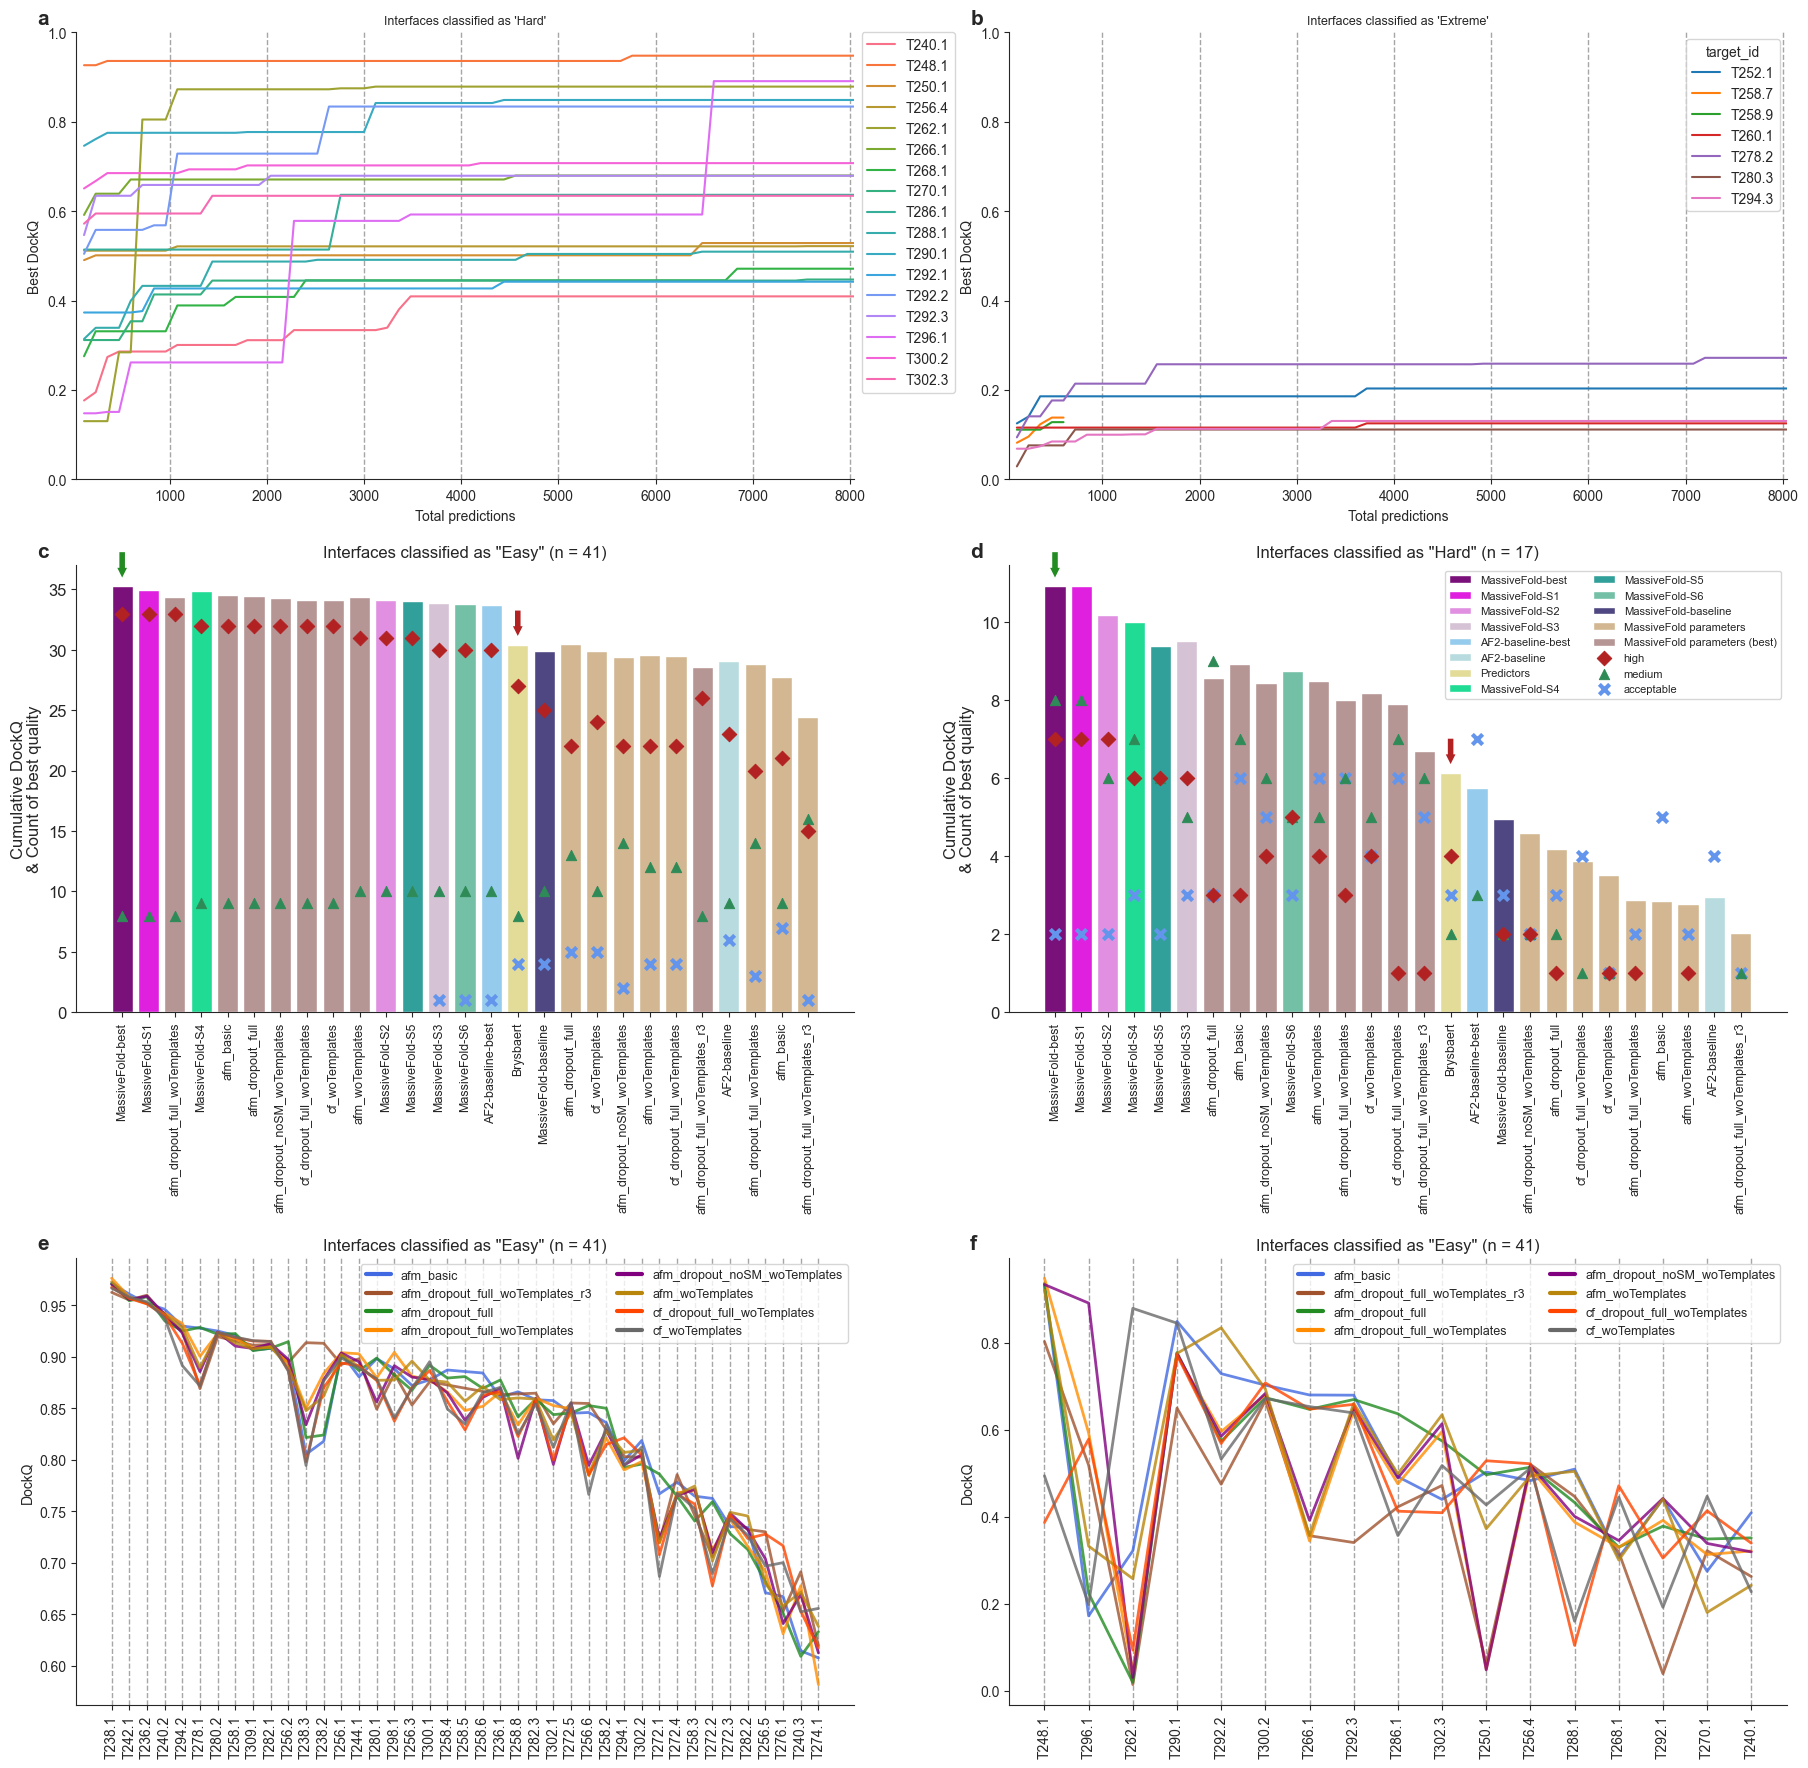

In [10]:
sns.set_style("ticks")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 16))
axes = axes.flatten()

styles = {"sizes": 55, "linewidth": {"high": 0.7, "medium": 0.7, "acceptable": 3}}
ylabel_fontsize, xlabel_fontsize, ytick_fontsize, xtick_fontsize, title_fontsize = 12, 12, 12, 9, 12
sampling_dockq["Total predictions"] = (1 + sampling_dockq["prediction"].copy())*15*8

# Fig S1a & b
for i, diff in enumerate(["hard", "extreme"]):
    axes_idx = [0, 1]
    ax = axes[axes_idx[i]]
    sns.lineplot(
        sampling_dockq[sampling_dockq["difficulty"] == diff],
        x="Total predictions",
        y="Best DockQ",
        hue="target_id",
        ax=ax
    )
    if i == 0:
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    ax.set_ylim(0, 1)
    ax.set_xlim(40, 8040)
    ax.set_title(f"Interfaces classified as '{diff.capitalize()}'", fontsize=9)

# Fig S1c & d
for i, (difficulty, location) in enumerate(zip(["easy", "hard"], [[1, 0], [1, 1]])):
    axes_idx = [2, 3]
    ax = axes[axes_idx[i]]
    df = sets[(sets["difficulty"] == difficulty)].copy()
    final_df, ax = plot_ranking(df, ax=ax, palette=all_palette, new_styles=styles)
    ax.set_ylabel("Cumulative DockQ\n& Count of best quality", fontsize=ylabel_fontsize)
    ax.tick_params(axis='y', labelsize=ytick_fontsize)
    ax.tick_params(axis='x', labelsize=xtick_fontsize)
    ax.set_title(f'Interfaces classified as "{difficulty.capitalize()}" (n = {len(df["target_id"].unique())})', fontsize=title_fontsize)
    if i == 0:
        ax.get_legend().remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, ncol=2, fontsize=8)

set_names = [ i for i in sets["name"].unique() if not i.startswith('MassiveFold') and not i.startswith('AF2') and not i == "Brysbaert" ]
palette = { sname: parameter_palette[sname] for sname in set_names }
legend_handles = [
    matplotlib.lines.Line2D([0], [0], color=color, lw=3, label=label)
    for label, color in palette.items()
]

# Figure S1e & f
for i, diff in zip([4, 5], ["easy", "hard"]): 
    ax = axes[i]
    for sname in set_names:
        sns.lineplot(
            all_sets[all_sets["difficulty"] == diff],
            x="target_id",
            y=sname,
            c=parameter_palette[sname],
            linewidth=2,
            ax=ax,
            alpha=0.8
        )
    ax.set_ylabel('DockQ')
    ax.set_xlabel('')
    ax.legend(handles=legend_handles, ncol=2, fontsize=9, loc="upper right")
    ax.set_title(f'Interfaces classified as "Easy" (n = 41)', fontsize=title_fontsize)
    ax.tick_params(axis='x', rotation=90)

# grid style and titles
for i, letter in enumerate(['a', 'b', 'c', 'd', 'e', 'f']):
    axes[i].set_title(f"{letter}",  loc="left", fontweight="bold", x=-.05, fontsize=15)
    if i in [0, 1, 4, 5]:
        axes[i].grid(
            axis='x',           # Only vertical lines
            linestyle='--',     # Dashed lines
            color='gray',       # Gray color
            linewidth=1,
            alpha=0.7
        )
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=-10.0)
for i in [4, 5]:
    pos = axes[i].get_position()
    axes[i].set_position([pos.x0 , pos.y0 - 0.1, pos.width, pos.height])
    
plt.show()
#fig.savefig("./Figure_S1.png", dpi=300, bbox_inches="tight", pad_inches=0.1)

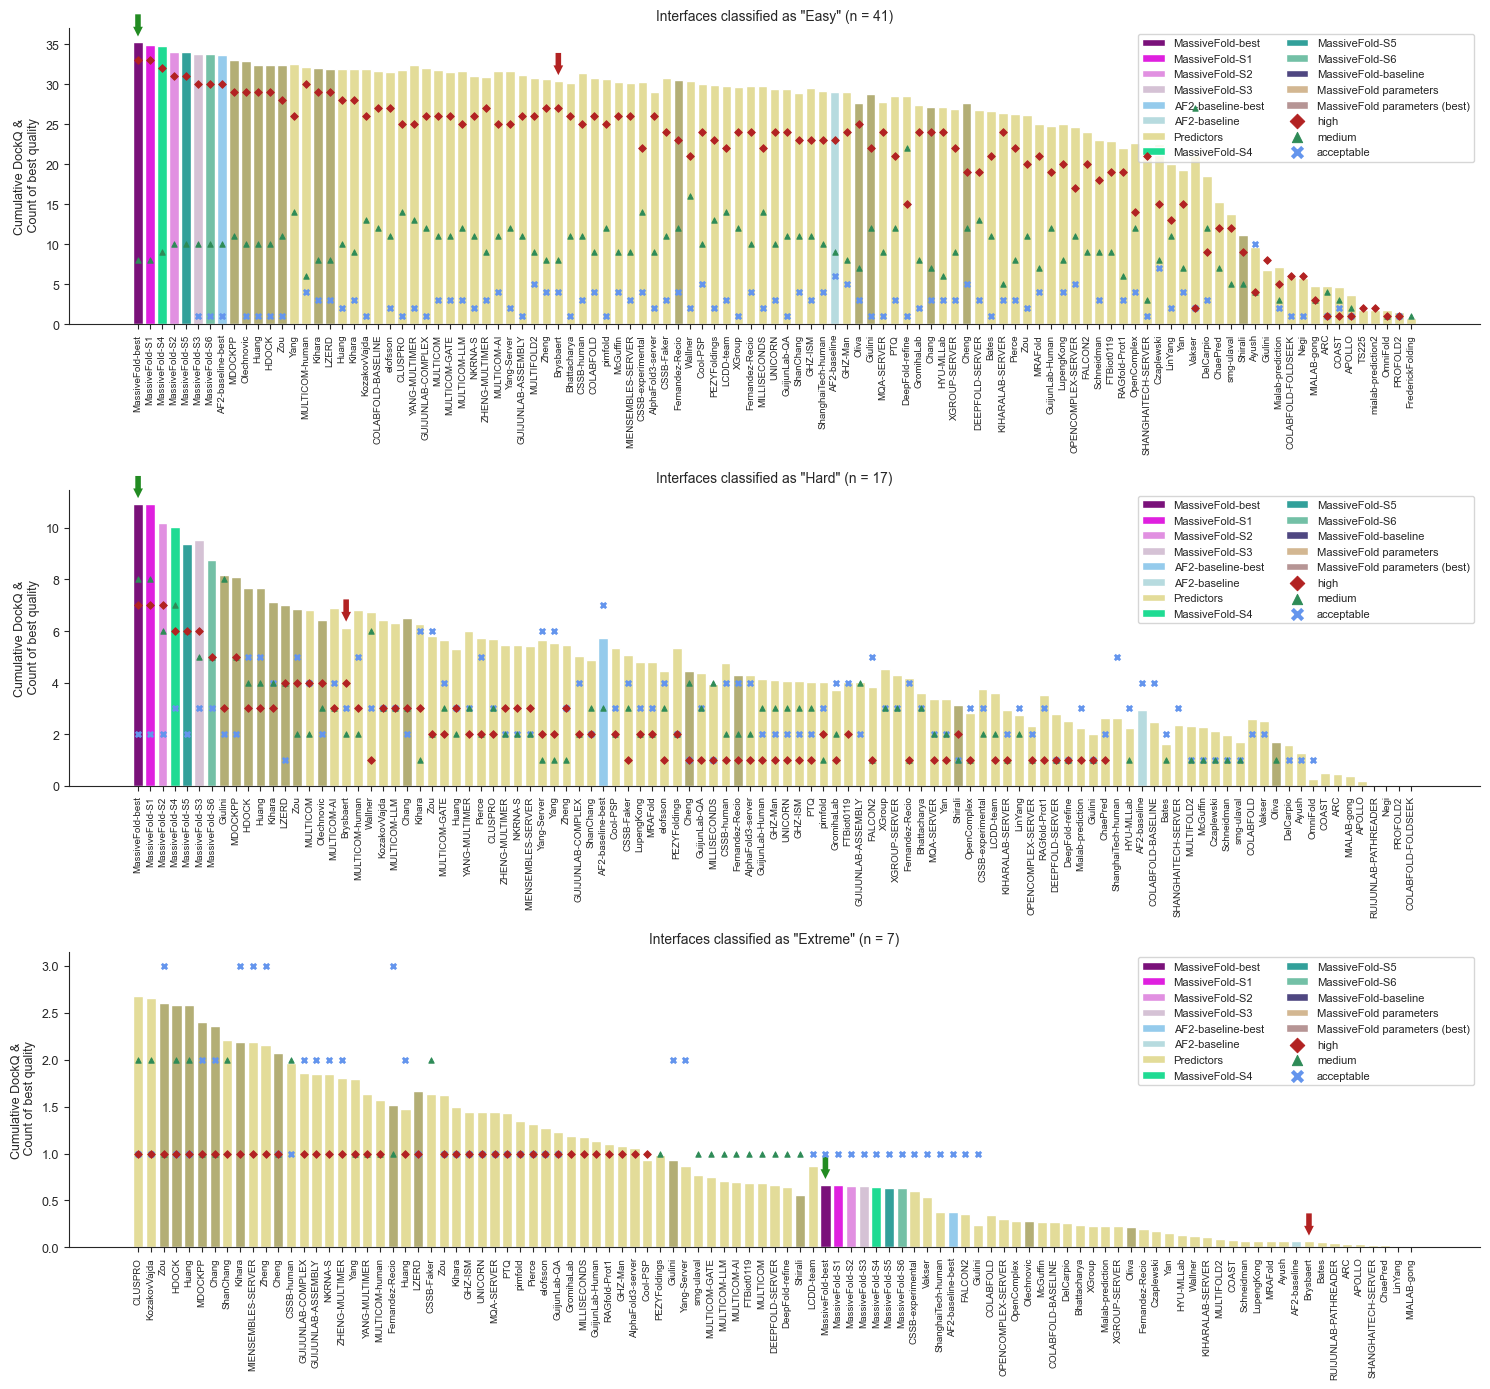

In [11]:
sns.set_style('ticks')
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 14))
ylabel_fontsize, xlabel_fontsize, ytick_fontsize, xtick_fontsize, title_fontsize = 9, 9, 9, 7, 10
styles = {"sizes": 15, "linewidth": {"high": 0.7, "medium": 0.7, "acceptable": 2}}
for i, (ax, difficulty) in enumerate(zip(axes.flatten(), ["easy", "hard", "extreme"])):
    df = strategies[(strategies["difficulty"] == difficulty)].copy()
    final_df, ax = plot_ranking(df, ax=ax, palette=all_palette, new_styles=styles)
    ax.set_ylabel("Cumulative DockQ &\n Count of best quality", fontsize=ylabel_fontsize)
    ax.tick_params(axis='y', labelsize=ytick_fontsize)
    ax.tick_params(axis='x', labelsize=xtick_fontsize)
    ax.set_title(f'Interfaces classified as "{difficulty.capitalize()}" (n = {len(df["target_id"].unique())})', fontsize=title_fontsize)
    ax.legend(handles=handles, ncol=2, fontsize=8)
plt.tight_layout()
plt.show()
#plt.savefig("./Figure_S2.png", dpi=300)

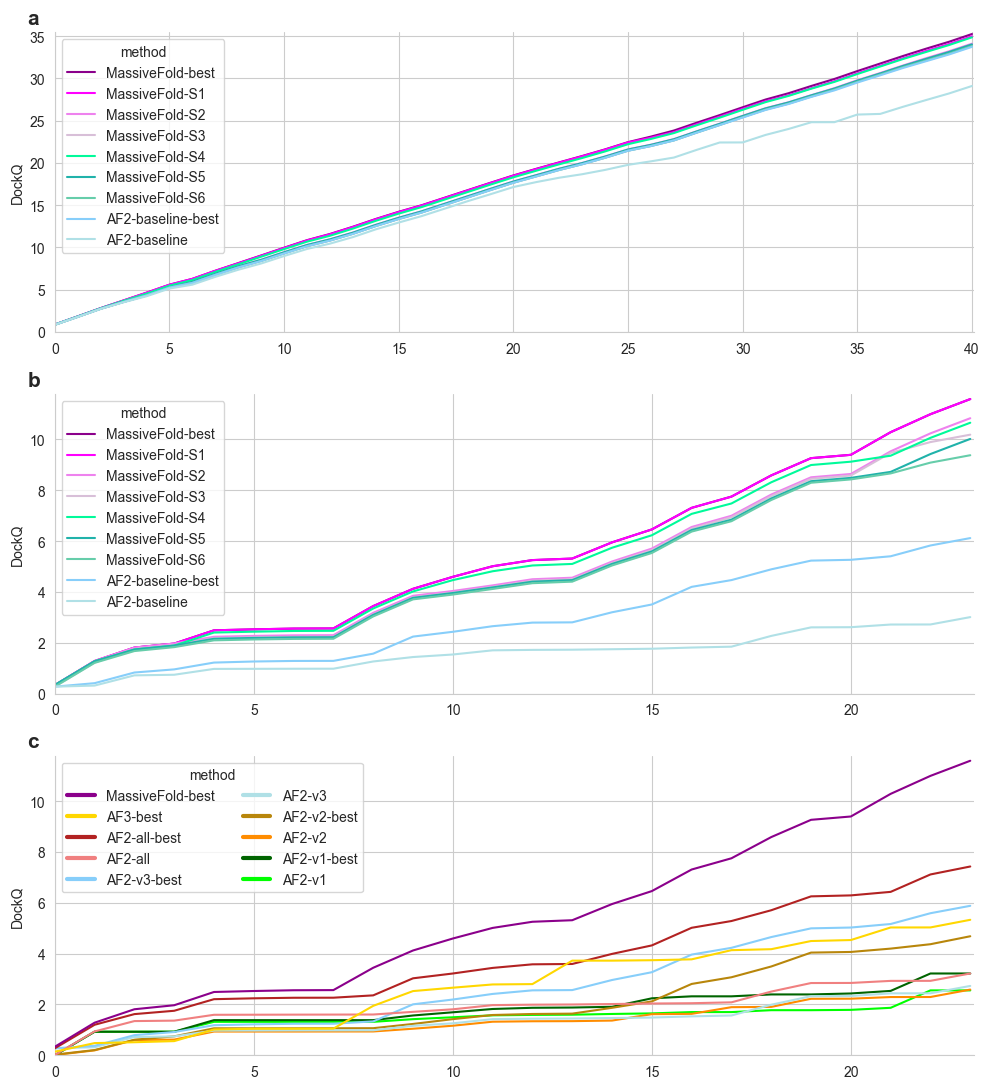

In [12]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))
for i, diff_df in enumerate([easy, hard]):
    sns.lineplot(diff_df, x=diff_df.index, y='dockq', hue="method",
                 ax=axes[i], palette=all_palette)

df_selected = df_methods[df_methods["difficulty"] != "easy"].reset_index()

for i, method in enumerate(all_methods):
    df_selected[method] = df_selected[method].cumsum()
    sns.lineplot(df_selected, x=df_selected.index, y=method,
                 color=all_palette[method], ax=axes[2], zorder=20-i)

method_palette = { i: all_palette[i] for i in all_methods }
legend_handles = [
    matplotlib.lines.Line2D([0], [0], color=color, lw=3, label=label)
    for label, color in method_palette.items()
]
axes[2].legend(handles=legend_handles, ncol=2, title="method", loc="upper left")
for i, diff_df in enumerate([easy, hard, hard]):
    axes[i].set_xlabel('')
    axes[i].set_ylabel('DockQ')
    axes[i].set_ylim(0, diff_df[diff_df["method"] == "MassiveFold-best"]["dockq"].max() + 0.2)
    axes[i].set_xlim(0, len(diff_df[diff_df["method"] == "MassiveFold-best"]) - .9)
    axes[i].set_title(['a', 'b', 'c'][i],  loc="left", fontweight="bold", x=-.03, fontsize=15)
sns.despine()
plt.tight_layout()
plt.show()
#plt.savefig('./Figure_S3.png', dpi=300)

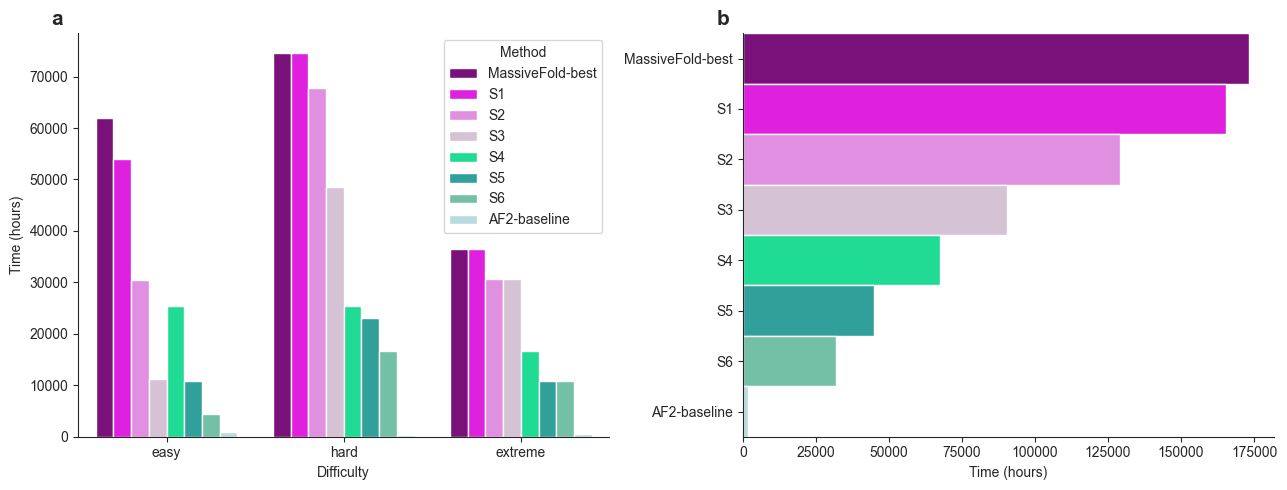

In [13]:
sns.set_style('ticks')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
axes = axes.flatten()

result_times = pd.DataFrame({"Method": final_methods, "Difficulty": difficulties, "Time (hours)": m_times})
sns.barplot(result_times, x="Difficulty", y="Time (hours)", 
            hue="Method", palette=all_palette, ax=axes[0])

all_diffs = result_times.groupby("Method")["Time (hours)"].sum().reset_index().sort_values('Time (hours)', ascending=False, ignore_index=True)
sns.barplot(all_diffs, y='Method', x='Time (hours)', hue='Method',
            palette=all_palette, ax=axes[1], width=1)
axes[1].set_ylabel('')

for i, letter in enumerate(['a', 'b']):
    axes[i].set_title(f"{letter}",  loc="left", fontweight="bold", x=-.05, fontsize=15)
    
sns.despine()
plt.tight_layout()
plt.show()
#plt.savefig('./Figure_S4.png', dpi=300)

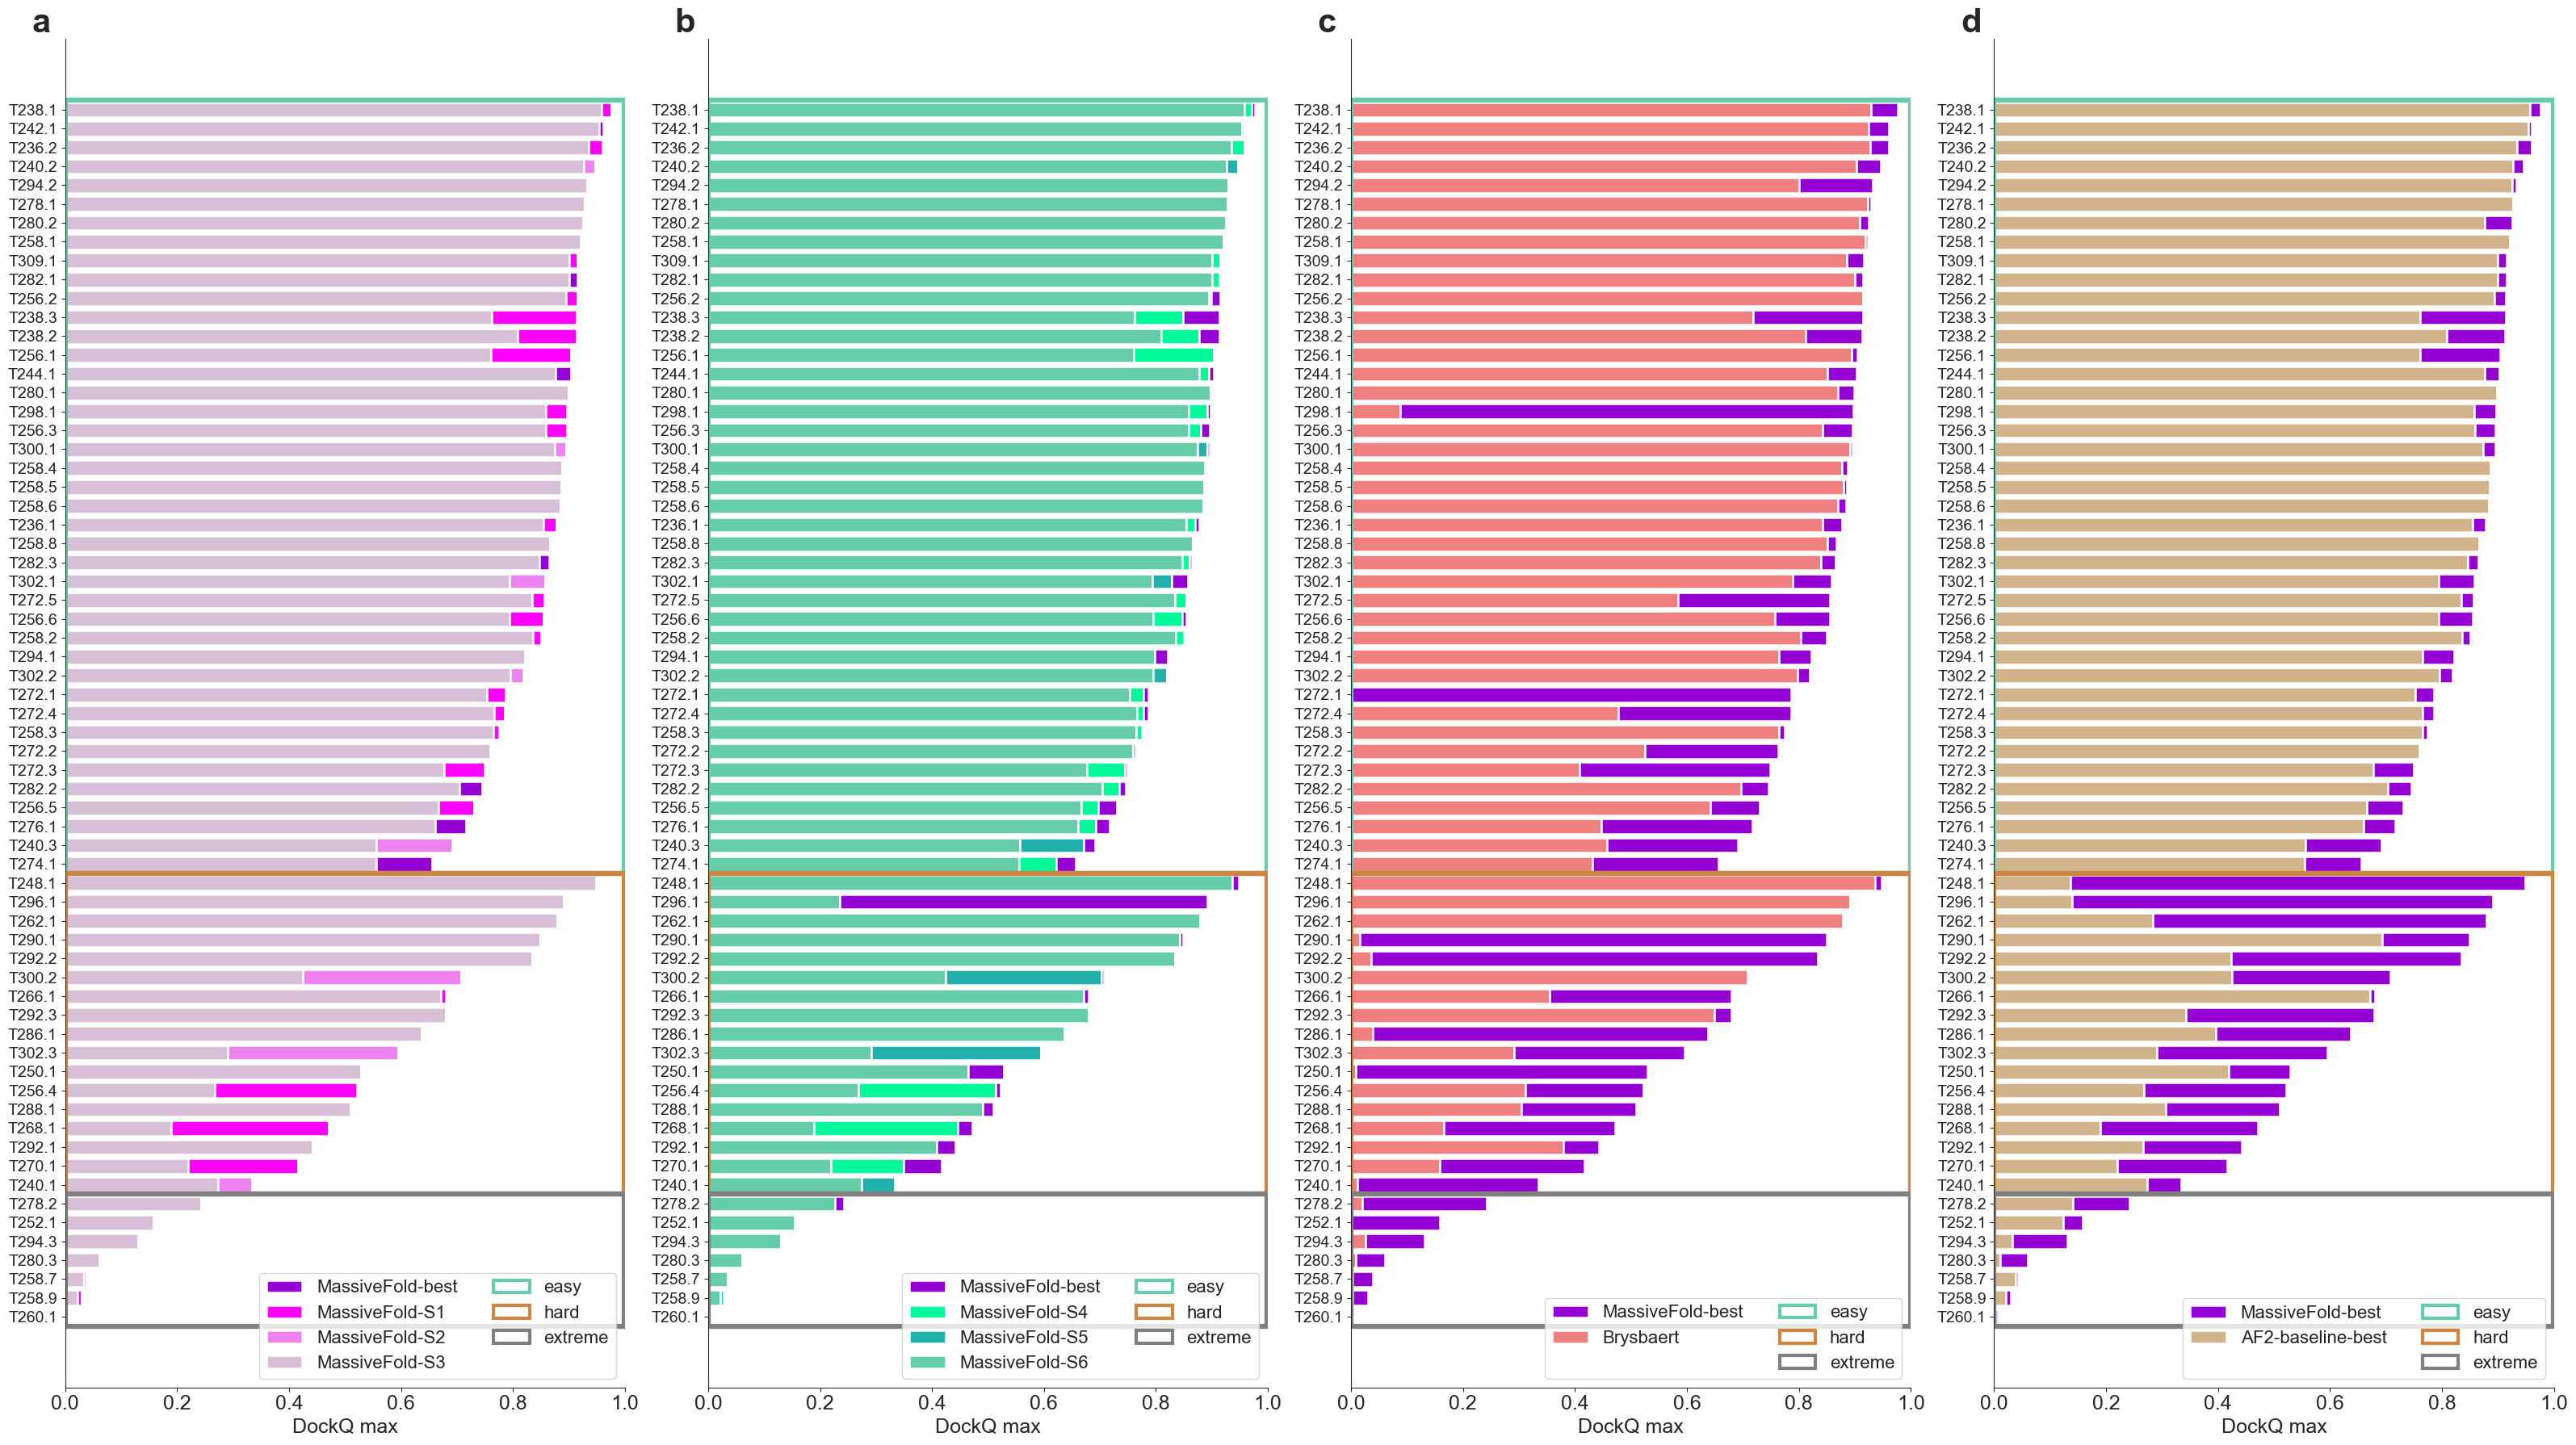

In [14]:
sns.set_style('ticks')
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(32, 18))
axes = axes.flatten()

# make the barplots
for i, _ in enumerate(compa_results):
    df = compa_results[i]
    df["difficulty"] = pd.Categorical(df["difficulty"], categories=difficulty_order, ordered=True)
    df_sorted = df.sort_values(["difficulty", 'all'], ascending=False).reset_index(drop=True)
    edge_colors = df_sorted["difficulty"].map(edgecolor_map)
    cols = all_columns[i]
    face_colors = all_colors[i]
    y_pos = np.arange(len(df_sorted))
    left = np.zeros(len(df_sorted))
    for col, fc in zip(cols, face_colors):
        axes[i].barh(y_pos, df_sorted[col], left=left, facecolor=fc, linewidth=1.8, label=col)
        left += df_sorted[col]
    
# draw rectangle around each difficulty group
bar_h = 0.8
pad, width   = 0.1, 0.999
diff_order = ["easy", "hard", "extreme"]
for diff in diff_order:
    ec   = edgecolor_map[diff]
    mask = df_sorted["difficulty"] == diff
    ys   = np.where(mask)[0]
    if len(ys) == 0:
        continue
    y0     = ys.min() - bar_h/2 - pad
    height = (ys.max() - ys.min()) + bar_h + 2*pad
    for ax in axes:
        ax.add_patch(matplotlib.patches.Rectangle(
            (0, y0), width, height, fill=False, edgecolor=ec, linewidth=4.5,
        ))

# axes parameters and 2 cols legend
for ax in axes:
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("DockQ max", fontsize=18)
    ax.set_yticks(y_pos)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=18)
    ax.set_yticklabels(df_sorted["target_id"])
    ax.set_xlim(0, 1)
    ax.invert_yaxis()
    model_h, model_l = ax.get_legend_handles_labels()
    hdict = dict(zip(model_l, model_h))
    model_l  = [ n for n in name_order if n in hdict ]
    model_h = [ hdict[n] for n in model_l ]
    if len(model_l) == 2:
        model_h.append(matplotlib.patches.Patch(facecolor="none", edgecolor="none", label=""))
        model_l.append("")
    diff_h = [
        matplotlib.patches.Patch(facecolor="none", edgecolor=edgecolor_map[d], linewidth=3)
        for d in diff_order
    ]
    diff_l = diff_order
    handles = model_h + diff_h
    labels  = model_l + diff_l
    ax.legend(handles, labels, ncol=2, loc="lower right", fontsize=16)
    for i, letter in enumerate(['a', 'b', 'c', 'd']):
        axes[i].set_title(f"{letter}", loc="left", fontweight="bold", x=-.06, fontsize=30)

plt.tight_layout()
plt.show()
#plt.savefig('./Figure_S5.png', dpi=300)

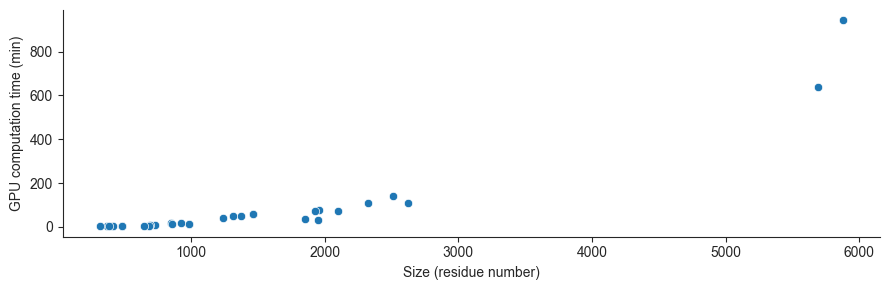

In [15]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(9, 3))
sns.scatterplot(
    time_vs_size,
    x='size',
    y='time(min)',
    ax=ax
)
ax.set_xlabel('Size (residue number)')
ax.set_ylabel('GPU computation time (min)')
plt.tight_layout()
sns.despine()
plt.savefig("./size_vs_time.png", dpi=200)

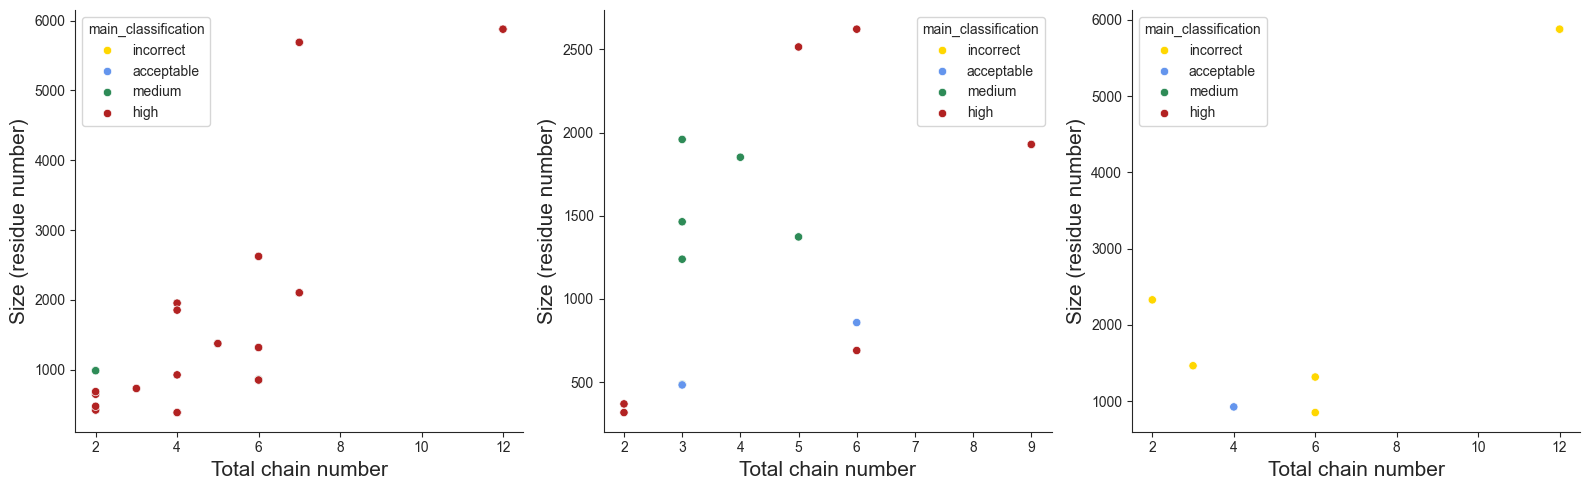

In [16]:
fig, axes = plt.subplots(figsize=(16, 5), ncols=3, nrows=1)
colors = {'high': 'firebrick', 'medium': 'seagreen', 'acceptable': 'cornflowerblue', 'incorrect': 'gold'}

for i, diff in enumerate(factors["difficulty"].unique()):
    ax=axes.flatten()[i]
    sns.scatterplot(
        factors[factors["difficulty"] == diff],
        x='total_chains',
        y='size',
        hue='main_classification',
        palette=colors,
        ax=ax
    )
    ax.set_xlabel('Total chain number', fontsize=15)
    ax.set_ylabel('Size (residue number)', fontsize=15)
sns.despine()
plt.tight_layout()
plt.savefig('./size_on_diff.png', dpi=250)

/tmp/ipykernel_21562/1576847016.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = factors[factors["difficulty"]=="easy"].groupby(['oligomerization', 'main_classification']).size().reset_index(name='count')
/tmp/ipykernel_21562/1576847016.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = factors.groupby(['oligomerization', 'main_classification']).size().reset_index(name='count')


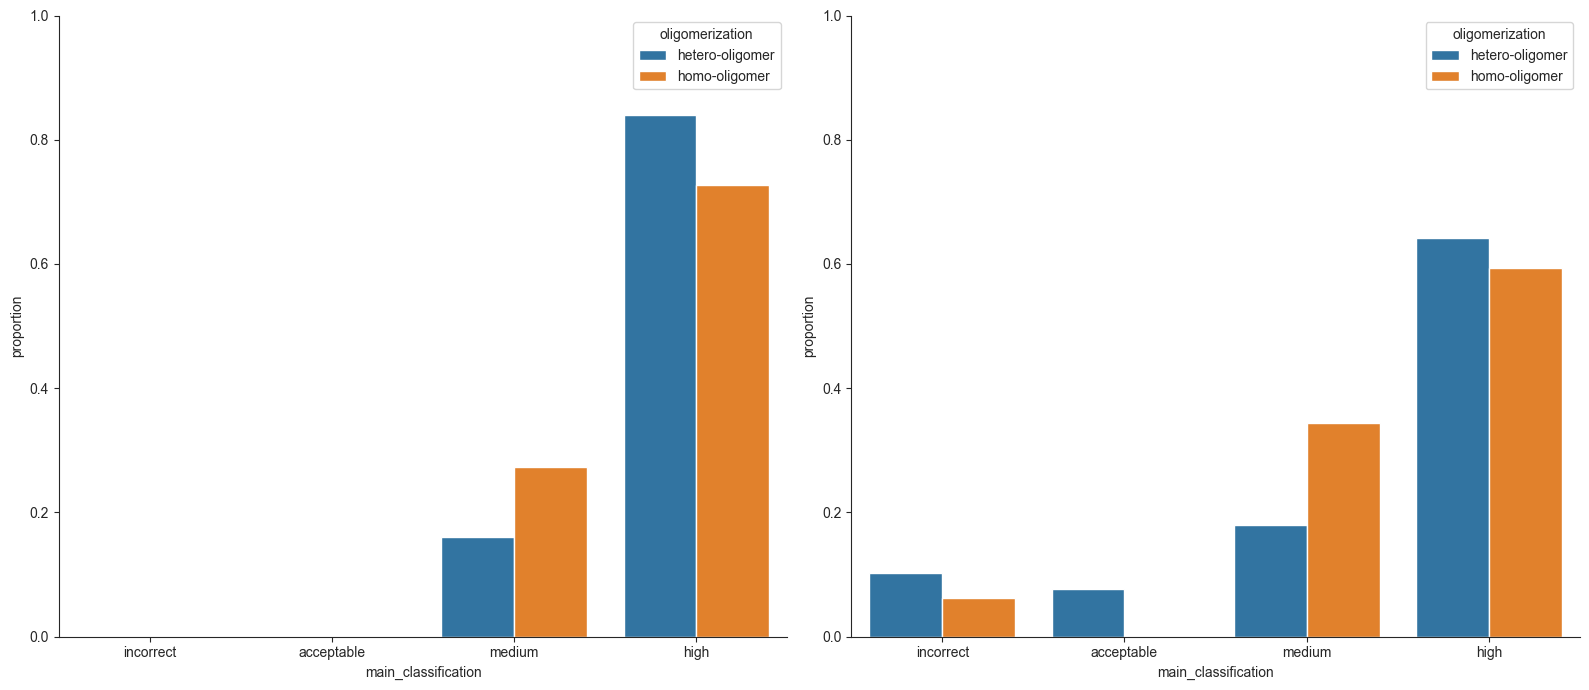

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

axes=axes.flatten()

count_df = factors[factors["difficulty"]=="easy"].groupby(['oligomerization', 'main_classification']).size().reset_index(name='count')
count_df = count_df.merge(
    count_df.groupby(["oligomerization"])["count"].sum().reset_index().rename(columns={'count': 'max'}),
    on='oligomerization',
    how='left')
count_df['proportion'] = count_df["count"] / count_df["max"]

sns.barplot(
    data=count_df,
    x='main_classification',
    y='proportion',
    hue='oligomerization',
    ax=axes[0]
)
axes[0].set_ylim(0, 1)
count_df = factors.groupby(['oligomerization', 'main_classification']).size().reset_index(name='count')
count_df = count_df.merge(
    count_df.groupby(["oligomerization"])["count"].sum().reset_index().rename(columns={'count': 'max'}),
    on='oligomerization',
    how='left')
count_df['proportion'] = count_df["count"] / count_df["max"]

sns.barplot(
    data=count_df,
    x='main_classification',
    y='proportion',
    hue='oligomerization',
    ax=axes[1]
)
axes[1].set_ylim(0, 1)
sns.despine()
plt.tight_layout()
plt.savefig("./oligotype_vs_perfs.png", dpi=250)

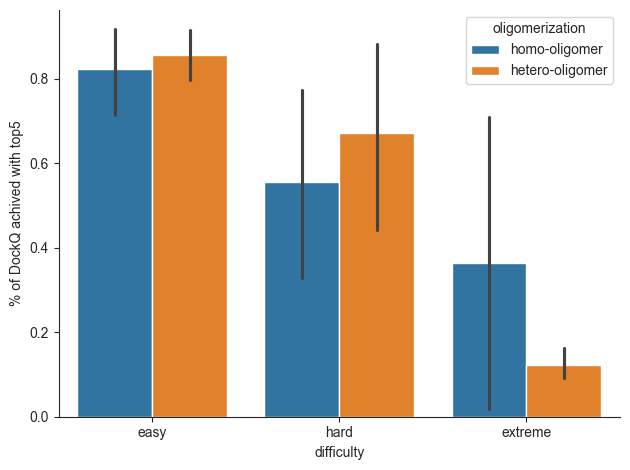

In [18]:
sns.barplot(
    factors,
    y='% of DockQ achived with top5',
    x='difficulty',
    hue='oligomerization'
)
sns.despine()
plt.tight_layout()
plt.savefig("max_dockq_completion_by_oligotype.png", dpi=250)